In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package

# This must be done if librep is not installed via pip,
# as this directory (examples) is appart from librep package root
sys.path.append("..")

# Third party imports
import pandas as pd
import numpy as np

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

2022-09-29 17:13:05.820278: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-29 17:13:05.820297: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
dataset_path = Path("../data/views/KuHar/resampled_view_20Hz")

In [4]:
# Kuhar dataframes
train, validation, test = PandasDatasetsIO(dataset_path).load()

In [5]:
train.head()

,Unnamed: 0,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,normalized activity code
0,0,0.001911,-0.014536,0.005845,0.003675,-0.014972,0.025607,0.000478,-0.031141,-0.014827,...,23.235,23.223,26.260,26.249,0,300,1,2100,1051,1
1,1,0.004114,-0.003186,0.000759,0.012450,-0.032074,0.007270,-0.000470,0.006980,0.021400,...,56.292,56.292,59.245,59.245,0,300,1,5700,1037,1
2,2,-0.011282,-0.002432,-0.003199,0.008152,-0.021763,0.000309,-0.004968,-0.009551,0.001497,...,27.268,27.267,30.290,30.291,0,300,1,2700,1075,1
3,3,-0.009241,-0.004666,0.021606,-0.007200,0.003091,0.001630,0.005057,-0.008149,0.013167,...,39.421,39.420,42.441,42.440,0,300,6,3900,1008,1
4,4,-0.013083,-0.005612,0.001645,0.006823,-0.004159,0.000415,0.008178,0.002637,-0.000827,...,23.703,23.703,26.656,26.656,0,300,1,2400,1038,1


In [6]:
# Kuhar features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_dataset = PandasMultiModalDataset(
    train,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Validation
validation_dataset = PandasMultiModalDataset(
    validation,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Test
test_dataset = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

In [7]:
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [8]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(transforms=[fft_transform], new_window_name_prefix="fft.")

In [9]:
train_dataset_fft = transformer(train_dataset)
validation_dataset_fft = transformer(validation_dataset)
test_dataset_fft = transformer(test_dataset)

In [10]:
print(train_dataset_fft.X.shape)
print(validation_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(3330, 180)
(108, 180)
(378, 180)


In [11]:
print(np.max(train_dataset_fft.X))

1182.4630044066


In [12]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
transform_topoae = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2',
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, Loss:410.4367, Loss-ae:387.9027, Loss-topo:22.5340
Epoch:2, Loss:417.2968, Loss-ae:333.8204, Loss-topo:83.4764
Epoch:3, Loss:282.9740, Loss-ae:281.5365, Loss-topo:1.4374
Epoch:4, Loss:258.9871, Loss-ae:257.6646, Loss-topo:1.3225
Epoch:5, Loss:249.2599, Loss-ae:248.1040, Loss-topo:1.1558
Epoch:6, Loss:243.4931, Loss-ae:242.3522, Loss-topo:1.1409
Epoch:7, Loss:240.2810, Loss-ae:239.0976, Loss-topo:1.1835
Epoch:8, Loss:217.6398, Loss-ae:215.8837, Loss-topo:1.7562
Epoch:9, Loss:203.8788, Loss-ae:201.8741, Loss-topo:2.0047
Epoch:10, Loss:199.8948, Loss-ae:196.2950, Loss-topo:3.5998
Epoch:11, Loss:210.5012, Loss-ae:204.7157, Loss-topo:5.7855
Epoch:12, Loss:200.1771, Loss-ae:198.2414, Loss-topo:1.9357
Epoch:13, Loss:254.0541, Loss-ae:238.4967, Loss-topo:15.5574
Epoch:14, Loss:216.4096, Loss-ae:214.8063, Loss-topo:1.6033
Epoch:15, Loss:184.0276, Loss-ae:181.9244, Loss-topo:2.1032
Epoch:16, Loss:186.7399, Loss-ae:182.8183, Loss-topo:3.9217
Epoch:17, Loss:170.5216, Loss-ae:168.6005, Los

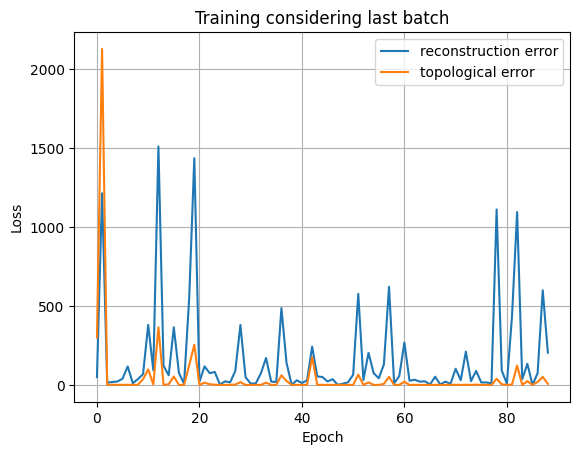

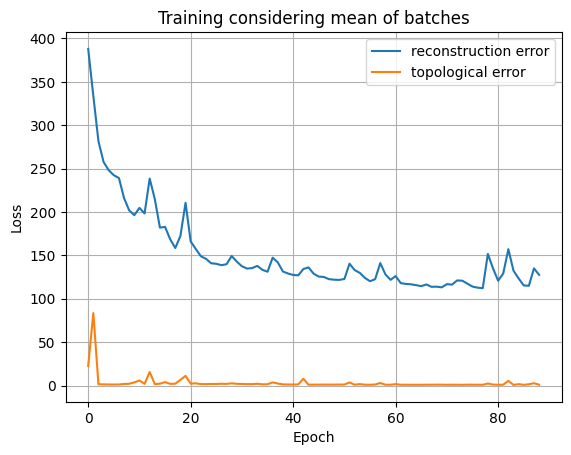

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


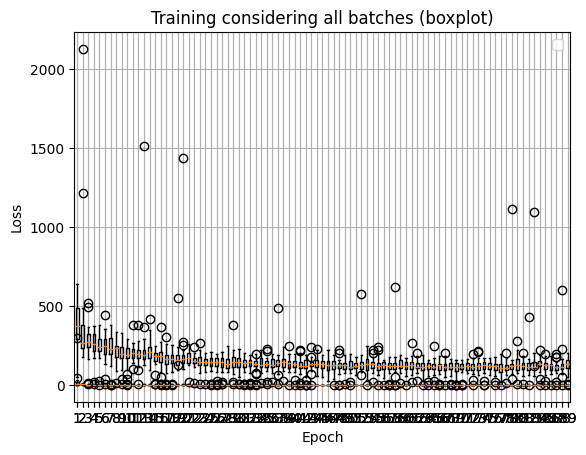

In [13]:
transform_topoae.fit(train_dataset_fft.X)
# assert 1==0

In [14]:
# for epoch_obj in transform_topoae.loss_components_values:
#     print(epoch_obj['epoch'])
#     epoch_obj_loss = [val.item() for val in epoch_obj['loss']]
#     print('loss - mean', np.mean(epoch_obj_loss))
#     # epoch_obj_loss_comp = [val.item() for val in epoch_obj['loss']]
#     temp1 = [val['loss.autoencoder'].item() for val in epoch_obj['loss_components']]
#     temp2 = [val['loss.topo_error'].item() for val in epoch_obj['loss_components']]
#     temp3 = [val['reconstruction_error'].item() for val in epoch_obj['loss_components']]
#     # epoch_obj_loss_components_loss_autoencoder
#     print('loss_components - loss.autoencoders - mean', np.mean(temp1))
#     print('loss_components - loss.topo_error - mean', np.mean(temp2))
#     print('loss_components - reconstruction_error - mean', np.mean(temp3) - np.mean(temp1))

In [15]:
test_applied_topoae = transform_topoae.transform(test_dataset_fft.X)
print('ORIGINAL', test_applied_topoae.shape)
test_applied_topoae = np.reshape(test_applied_topoae, (-1,2))
print('RESHAPED', test_applied_topoae.shape)

ORIGINAL (378, 1, 2)
RESHAPED (378, 2)


In [28]:
from librep.transforms import TSNE
import numpy as np
import matplotlib.pyplot as plt

def visualize(X, Y, filtered=None):
    data_grouped = list(zip(X, Y))
    uniques = filtered
    if filtered is None:
        uniques = np.unique(Y)
    
    for uval in uniques:
        data = [pair[0] for pair in data_grouped if pair[1]==uval]
        data_x = [unit[0] for unit in data]
        data_y = [unit[1] for unit in data]
        plt.scatter(data_x, data_y, label = uval)
    # print(data)
    plt.xlim((-0.5,1.5))
    plt.ylim((-1,0.5))
    plt.legend()
    plt.show()


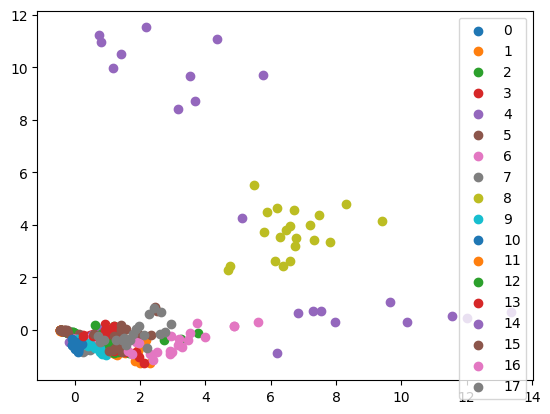

In [23]:
visualize(test_applied_topoae, test_dataset_fft.y)

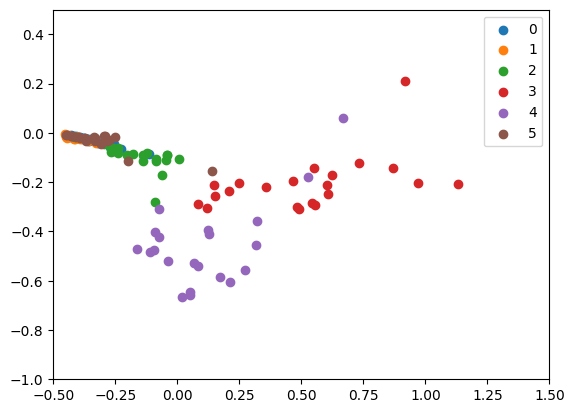

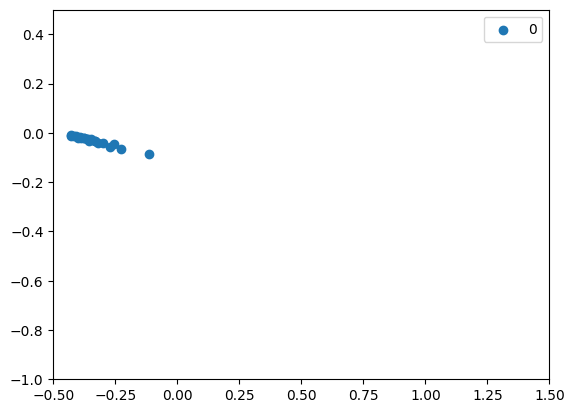

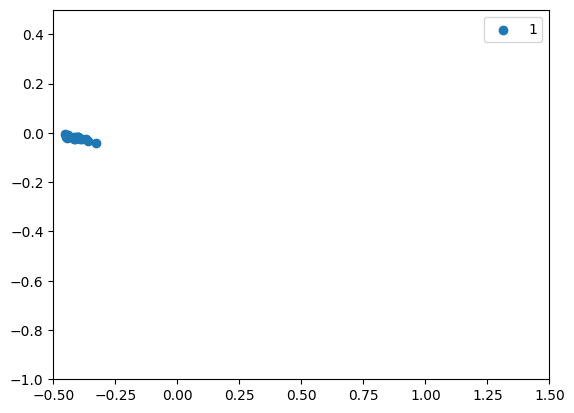

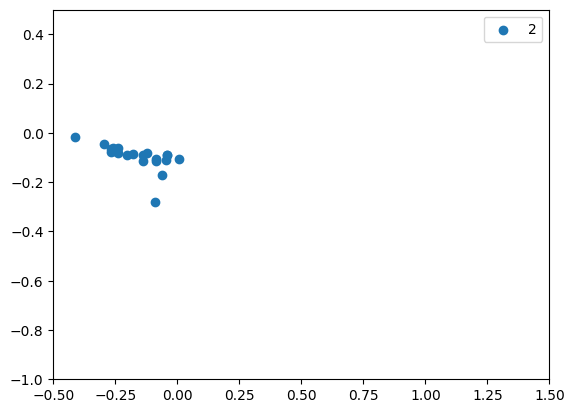

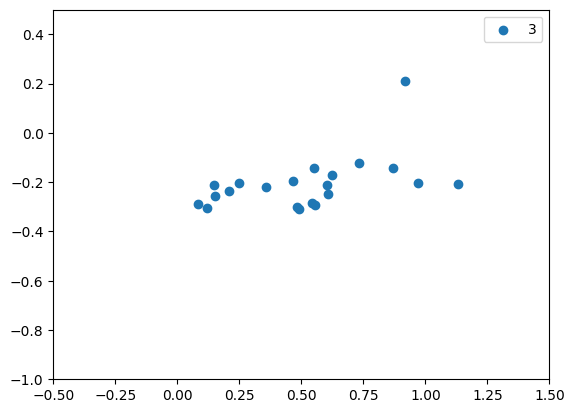

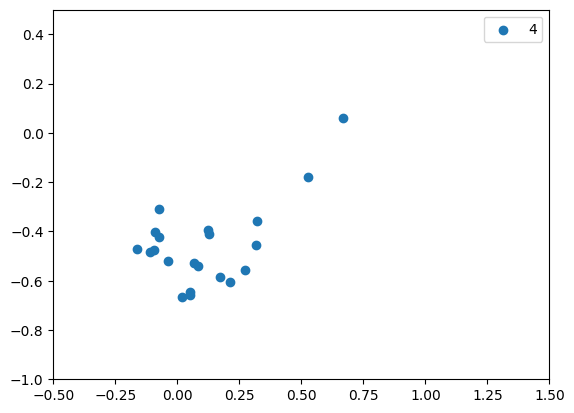

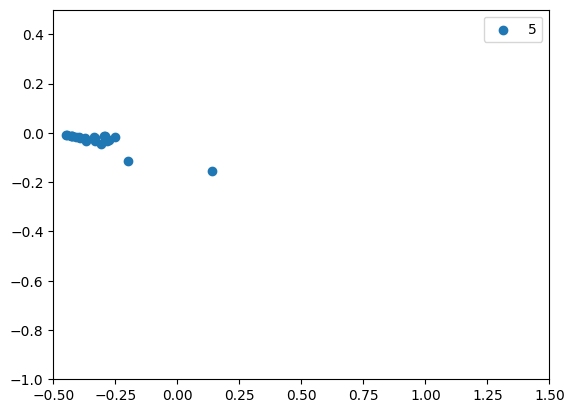

In [29]:
# filtered
filter_to_use = [0,1,2,3,4,5]
visualize(test_applied_topoae, test_dataset_fft.y, filtered=filter_to_use)
for f in filter_to_use:
    visualize(test_applied_topoae, test_dataset_fft.y, filtered=[f])
# visualize(test_applied_topoae, test_dataset_fft.y, filtered=[1])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

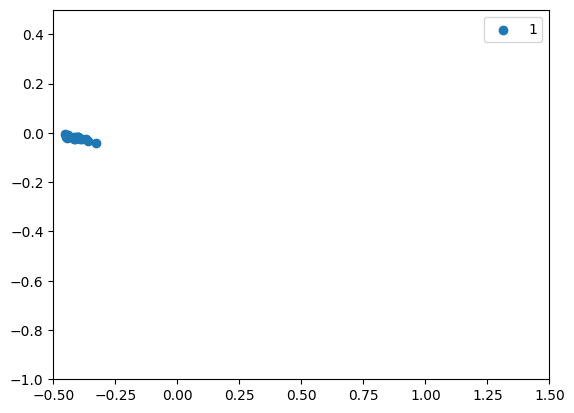

In [32]:
visualize(test_applied_topoae, test_dataset_fft.y, filtered=[1])

In [ ]:
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport
metrics_reporter = DimensionalityReductionQualityReport(sampling_threshold=378)
metrics_train_applied_topoae = metrics_reporter.evaluate([test_dataset_fft.X, test_applied_topoae])
print(metrics_train_applied_topoae)

In [ ]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier
from librep.metrics.report import ClassificationReport
import yaml

reporter = ClassificationReport(use_accuracy=True, use_f1_score=True, use_classification_report=False, use_confusion_matrix=False, plot_confusion_matrix=False)
experiment = SimpleTrainEvalWorkflow(estimator=RandomForestClassifier, estimator_creation_kwags ={'n_estimators':100} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

In [ ]:
combined_train_dset = PandasMultiModalDataset(
    pd.concat([train, validation]),
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)


result = multi_run_experiment(combined_train_dset, test_dataset)
print(yaml.dump(result, sort_keys=True, indent=4))

In [ ]:
combined_train_dset_fft = transformer(combined_train_dset)

result = multi_run_experiment(combined_train_dset_fft, test_dataset_fft)
print(yaml.dump(result, sort_keys=True, indent=4))

In [ ]:
print(train_dataset_fft.y)

print(combined_train_dset.data.shape)

In [ ]:
import pandas as pd

# Using the latent space
train_applied_topoae = transform_topoae.transform(train_dataset_fft.X)
print('ORIGINAL', train_applied_topoae.shape)
train_applied_topoae = np.reshape(train_applied_topoae, (-1,3))
print('RESHAPED', train_applied_topoae.shape)

train_applied_topoae_pd = pd.DataFrame(train_applied_topoae)
train_applied_topoae_pd['y'] = train_dataset_fft.y
# print('FINAL', train_applied_topoae_pd)


topoae_train_dset = PandasMultiModalDataset(
    train_applied_topoae_pd,
    label_columns="y",
    as_array=True
)

test_applied_topoae_pd = pd.DataFrame(test_applied_topoae)
test_applied_topoae_pd['y'] = test_dataset_fft.y
# print('FINAL', test_applied_topoae_pd)

topoae_test_dset = PandasMultiModalDataset(
    test_applied_topoae_pd,
    label_columns="y",
    as_array=True
)
result = multi_run_experiment(topoae_train_dset, topoae_test_dset)
print(yaml.dump(result, sort_keys=True, indent=4))

# Dimensionality exploration